# PERFORMING ML, DATA ANALYSIS AND VISUALIZATION IN PYTHON NOTEBOOK


In [1]:
# importing all neccassary files
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from SQL_query import *  # for connecting to MYSQL database

In [2]:
# connecting to a database using SQL_query.py file 
connection=create_conenction(host,user,password)
cursor=create_cursor(connection)

connection is successful <mysql.connector.connection.MySQLConnection object at 0x10ee34ca0>


In [3]:
query="USE accident"
execute_query(cursor,query,connection) 

## ML OLAP QUESTIONS ##

### As a safety adminstrator , I want to know which pipeline type has caused the oil spills and and do they have relation with cost loss ? ##


     Pipeline_Type         Cost  Spill_Counts
0      ABOVEGROUND   153.532553          1475
1      UNDERGROUND  2081.297168           985
2             TANK    81.382221           301
3  TRANSITION AREA     1.014763            16


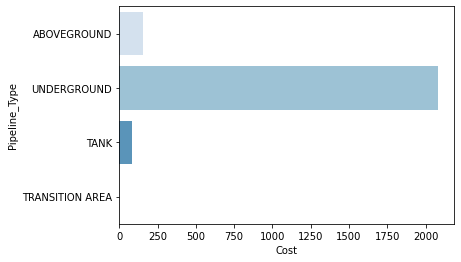

In [4]:
# Scale costs to $1M for plot clarity 

query1="""SELECT  p.Pipeline_Type, SUM(a.All_Costs)/1000000.0 as Cost,COUNT(*) as Spill_Counts
          FROM pipeline_table p 
          JOIN accident_costs_table a 
          ON p.Report_Number=a.Report_Number  
          WHERE p.Pipeline_Type IS NOT NULL 
          GROUP BY p.Pipeline_Type"""
df = pd.read_sql(query1,connection)
print(df)

sns.barplot(x=df["Cost"],y=df["Pipeline_Type"],orient="h",palette="Blues")
plt.show()


Here , we observe that although maximum accidents have taken place in pipelines located ABOVEGROUND but the total cost loss incurred is high in case of pipeline located UNDERGROUND .

### As a Accident/Incident Investigators,I want to know which 5 operators/causes are responsible for the most spills so further measure can be taken in these areas?

                       Operator_Name  Spill_Counts
0      ENTERPRISE CRUDE PIPELINE LLC           195
1               SUNOCO PIPELINE L.P.           180
2              PLAINS PIPELINE, L.P.           156
3  ENTERPRISE PRODUCTS OPERATING LLC           155
4      MAGELLAN PIPELINE COMPANY, LP           140


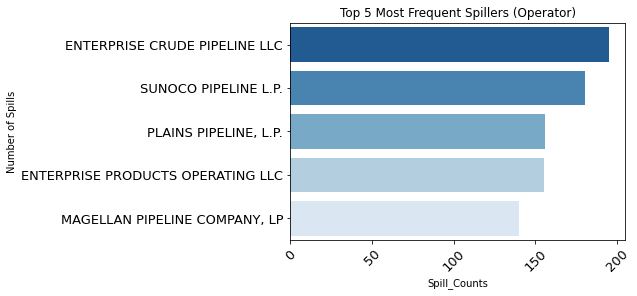

In [5]:
# to find top 5 Operators responsible for Oil Spill
query1="""SELECT Operator_Name,COUNT(*) as Spill_Counts 
          FROM operator_table 
          GROUP BY Operator_Name 
          ORDER BY Spill_Counts DESC LIMIT 5;"""
df = pd.read_sql(query1,connection)
print(df)

operator_count=df["Spill_Counts"]   
pal = sns.color_palette("Blues", len(operator_count))
rank = operator_count.argsort()
g=sns.barplot(y=df["Operator_Name"], x=operator_count, palette=np.array(pal[::])[rank],)
plt.title('Top 5 Most Frequent Spillers (Operator)')
plt.ylabel('Number of Spills')
plt.tick_params(labelsize=13)
plt.xticks(rotation=45)
plt.show()

                Cause_Category  Spill_Counts         Cost
0  MATERIAL/WELD/EQUIP FAILURE          1435  1243.774427
1                    CORROSION           592   395.325677
2          INCORRECT OPERATION           378   106.140454
3         NATURAL FORCE DAMAGE           118   220.354295
4             ALL OTHER CAUSES           118   110.824821


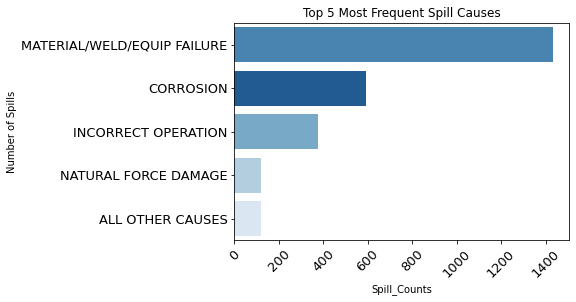

In [7]:
# to find top 5 Causes responsible for Oil Spill
query1="""SELECT p.Cause_Category,COUNT(*) as Spill_Counts ,SUM(a.All_Costs)/1000000.0 as Cost
          FROM pipeline_table p 
          JOIN accident_costs_table a 
          ON p.Report_Number=a.Report_Number
          GROUP BY p.Cause_Category 
          ORDER BY Spill_Counts DESC LIMIT 5;"""
df = pd.read_sql(query1,connection)
print(df)

total_category_count=df["Spill_Counts"] # data underlying bar plot 
pal = sns.color_palette("Blues", len(total_category_count))
rank = total_category_count.argsort()
g=sns.barplot(y=df["Cause_Category"], x=total_category_count, palette=np.array(pal[::])[rank],orient="h")
plt.title('Top 5 Most Frequent Spill Causes')
plt.ylabel('Number of Spills')
plt.tick_params(labelsize=13)
plt.xticks(rotation=45)
plt.show()

### As a new Data Analysts employed ,I want to know which year saw the most accidents and their associated cost ,Fatalities and Injuries.

In [6]:
query1="""SELECT Accident_Year,COUNT(*) as Spill_Counts ,SUM(All_Costs)/1000000.0 as Total_Cost,SUM(All_Fatalities) as Total_fatalities,SUM(All_Injuries) as Total_injuries
        FROM accident_detail 
        INNER JOIN accident_costs_table USING (Report_Number)
        INNER JOIN fatalities USING (Report_Number)
        INNER JOIN injuries_table USING (Report_Number)
        WHERE Accident_Year!=2017
        GROUP BY Accident_Year;
     """

df = pd.read_sql(query1,connection)
print(df)


   Accident_Year  Spill_Counts   Total_Cost  Total_fatalities  Total_injuries
0           2010           350  1075.193990               1.0             3.0
1           2011           345   273.526547               1.0             2.0
2           2012           366   145.247426               3.0             4.0
3           2013           401   278.525540               1.0             6.0
4           2014           454   131.684524               NaN             NaN
5           2015           462   253.696042               1.0             NaN
6           2016           415   173.161626               3.0             5.0


Here we observce that , the minimum number of Oil Spill Accidents took place in year 2010 but still the Total_cost loss incurred was highest in that year . 

## Making Prediction 

### As a businness analyst, I want to predict if on the basis of fatalities,Injuries and total loss incurred , can the Liquid Type be predicted, as in which Liquid cause the the spill can be predicted?

In [7]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_absolute_error,classification_report,r2_score

In [8]:
# reading data from MYSQL and executing query
query= """SELECT p.Liquid_Type ,a.`Unintentional_Release_(Barrels)`,
         a.`Intentional_Release_(Barrels)`,a.`Liquid_Recovery_(Barrels)`,
         a.`Net_Loss_(Barrels)`,c.Property_Damage_Costs,c.Lost_Commodity_Costs ,
         c.`Public/Private_Property_Damage_Costs`,c.Emergency_Response_Costs,
         c.Environmental_Remediation_Costs,c.Other_Costs,c.All_Costs
         FROM pipeline_table p,
         barrel_table a,
         accident_costs_table c
         WHERE a.Report_Number=p.Report_Number AND a.Report_Number=c.Report_Number;
"""
df = pd.read_sql(query,connection)

# printing shape of data and checking if data has correct number fo rows
print(df.shape)


(2795, 12)


In [9]:
# checking for non-null values in dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Liquid_Type                           2795 non-null   object 
 1   Unintentional_Release_(Barrels)       2795 non-null   float64
 2   Intentional_Release_(Barrels)         1209 non-null   float64
 3   Liquid_Recovery_(Barrels)             2795 non-null   float64
 4   Net_Loss_(Barrels)                    2795 non-null   float64
 5   Property_Damage_Costs                 2788 non-null   float64
 6   Lost_Commodity_Costs                  2791 non-null   float64
 7   Public/Private_Property_Damage_Costs  2785 non-null   float64
 8   Emergency_Response_Costs              2789 non-null   float64
 9   Environmental_Remediation_Costs       2787 non-null   float64
 10  Other_Costs                           2779 non-null   float64
 11  All_Costs        

In [10]:
# Since Intentional_Release_(Barrels) has moew than 50 % values as null as understood from df.info(),
# we will drop the column
df.drop("Intentional_Release_(Barrels)",axis=1,inplace=True)

In [11]:
print(df.columns)

Index(['Liquid_Type', 'Unintentional_Release_(Barrels)',
       'Liquid_Recovery_(Barrels)', 'Net_Loss_(Barrels)',
       'Property_Damage_Costs', 'Lost_Commodity_Costs',
       'Public/Private_Property_Damage_Costs', 'Emergency_Response_Costs',
       'Environmental_Remediation_Costs', 'Other_Costs', 'All_Costs'],
      dtype='object')


In [12]:
# checking the number of unique values in our target variable
print(df["Liquid_Type"].value_counts())

"""Since Rating Text contains text for rating we need to convert it into numerical columns """ 
# we can also use Label Encoder for sklearn

df["Liquid_Type"]=df["Liquid_Type"].map({"BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)":0,
                                         "CO2 (CARBON DIOXIDE)" :1,
                                         "HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS":2,
                                         "REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID":3,
                                         "CRUDE OIL":4 })

# checking the unique values if mapping has been done successfully.
print(df["Liquid_Type"].unique())

CRUDE OIL                                               1398
REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID       939
HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS               418
CO2 (CARBON DIOXIDE)                                      38
BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)       2
Name: Liquid_Type, dtype: int64
[2 4 3 1 0]


In [13]:
# X is a set of independent variables (features) and y is dependent variable (target variable)

X = df[['Unintentional_Release_(Barrels)',
       'Liquid_Recovery_(Barrels)', 'Net_Loss_(Barrels)',
       'Property_Damage_Costs', 'Lost_Commodity_Costs',
       'Public/Private_Property_Damage_Costs', 'Emergency_Response_Costs',
       'Environmental_Remediation_Costs', 'Other_Costs', 'All_Costs']]
y = df[['Liquid_Type']]

In [14]:
# Handling missing values is a key part of data preprocessing

imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # axis=0 for columns 

imputer = imputer.fit(X.iloc[:,3:])
X.iloc[:,3:] = imputer.transform(X.iloc[:,3:])


/Users/surbhi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-14-9519679c879c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.iloc[:,3:] = imputer.transform(X.iloc[:,3:])


In [15]:
'''Performing train/test split using 80:20 split'''

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 100)

print(f'Shape of x_train is {x_train.shape}')
print(f'Shape of x_test is {x_test.shape}')

Shape of x_train is (2236, 10)
Shape of x_test is (559, 10)


## Fitting the model using Decision Tree Classifier

In [16]:
model = DecisionTreeClassifier(criterion = 'gini')
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [17]:
''' Testing the accuracy using test dataset '''
from sklearn.metrics import accuracy_score
print('Testing accuracy is: ', accuracy_score(model.predict(x_test), y_test))

Testing accuracy is:  0.5760286225402504


In [18]:
print('Testing accuracy is: ', accuracy_score(model.predict(x_test), y_test))

Testing accuracy is:  0.5760286225402504


### Accuracy is very low at 56% using Decision Tree Classifier

## Applying a differnt model RandomForestClassifier to see if accuracy improves

In [19]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
# https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected

clf.fit(x_train,y_train.values.ravel())

y_pred=clf.predict(x_test)

In [20]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.6529516994633273


## Though the accuracy is low in both models, but with the use of Random forest clasifers, accuracy has been improved to 65% .

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.74      0.79      0.76        75
           3       0.58      0.47      0.52       190
           4       0.67      0.75      0.71       289

    accuracy                           0.65       559
   macro avg       0.40      0.40      0.40       559
weighted avg       0.64      0.65      0.65       559



/Users/surbhi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
